In [1]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, matthews_corrcoef
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
sys.path.append('./data/')
sys.path.append('./models/')
from thmodel import *
import pickle
with open('./data/dict_data_final.pkl', 'rb') as f:
    data = pickle.load(f)

x, y = data['Beneixama']

# Parámetros $\Gamma$

In [2]:
list_P = [
    [0, 0.1, 0.5, 0.9, 1.01],
    [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.01],
    [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.01],
]

P1, P2, P3 = list_P[0], list_P[1], list_P[2]

# Análisis inicial

In [3]:
grid = Grid(x=x, y=y, mode='gumbel')
grid.initialize(part=P2)
grid.compute_th_param(grad=True)
grid.submatrix()
grid.enlargement_process()
grid.montecarlo(n_it=100)

<AxesSubplot:>

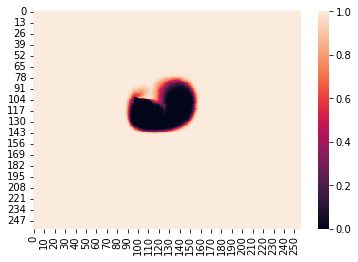

In [4]:
sns.heatmap(grid.X0[:, :, -1].detach().numpy())

<AxesSubplot:>

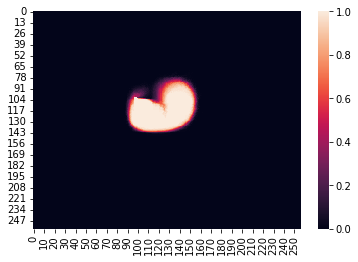

In [5]:
sns.heatmap(1 - grid.X0[:, :, -1].detach().numpy())

In [6]:
grid.X[:, :, -1]

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [7]:
Xf = torch.where(
    grid.X[:, :, -1] == 0,
    grid.X0[:, :, -1],
    1 - grid.X0[:, :, -1]
)
Y = (y[:, :, -1] != 0)*1

In [8]:
Xf.min()

tensor(0.3600, grad_fn=<MinBackward1>)

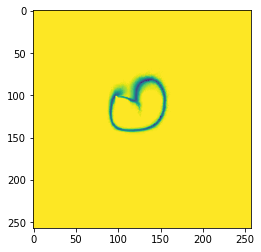

In [9]:
plt.imshow(Xf.detach().numpy())

# Loss function

In [10]:
X = torch.stack([grid.X0[:, :, -1].flatten(), 1 - grid.X0[:, :, -1].flatten()], dim=-1)
w = torch.where(
    torch.from_numpy(y[:, :, -1] == 0),
    torch.from_numpy(y[:, :, -1] != 0).sum(),
    torch.from_numpy(y[:, :, -1] == 0).sum()
)/(257**2)

In [11]:
loss = nn.BCELoss(weight=w.flatten().reshape(-1, 1))

# Bucle de entrenamiento

In [12]:
##### data #####

x, y = data['Beneixama']
y_t = torch.from_numpy(y).float()
Y = (y[:, :, -1] != 0)*1

##### parameters #####
grad = True
alpha = torch.tensor(2., requires_grad=grad).float()
beta = torch.tensor(2., requires_grad=grad).float()
gamma = torch.tensor(1.25, requires_grad=grad).float()
t_min = 0
discount = 0.95
alphas, betas, gammas = [alpha], [beta], [gamma]
n_epochs = 10
lr = 0.2

##### weights #####

w = torch.where(
    torch.from_numpy(y[:, :, -1] == 0),
    torch.from_numpy(y[:, :, -1] != 0).sum(),
    torch.from_numpy(y[:, :, -1] == 0).sum()
)/(257**2)

##### loss & metrics #####

loss = nn.BCELoss(weight=w.flatten().reshape(-1, 1))
optimizer = torch.optim.Adam([alpha, beta, gamma], lr=lr)
losses = []
accuracys = []
f1s = []
mccs = []
fps = []
fns = []

##### index #####

ind_loss = np.argwhere(x.Train.values == True).flatten() + 1

In [13]:
for epoch in range(n_epochs):

    print(f'Epoch {epoch+1}/{n_epochs}')

    grid = Grid(x=x, y=y, mode='gumbel')
    grid.initialize(part=P2)
    f = (grid.Temp - t_min)**alpha
    g = (grid.Hum)**beta
    grid.div = 1 + gamma * (g/f)
    grid.p0 = 1 / grid.div
    grid.submatrix()
    grid.enlargement_process()
    grid.montecarlo(n_it=50)

    loss_total = 0.
    loss_total = loss(
        torch.stack(
            [grid.X0[:, :, -1].flatten(), 1 - grid.X0[:, :, -1].flatten()], 
            dim=-1
        ).float(),
        torch.stack(
            [((y_t[:, :, -1] == 0)*1).flatten(), ((y_t[:, :, -1] != 0)*1).flatten()],
            dim=-1
        ).float()
    )
    
    ##### metrics #####
    X = (grid.X[:, :, -1].numpy() != 0)*1
    cmat = confusion_matrix(Y.flatten(), X.flatten(), normalize='true')
    accuracys.append(accuracy_score(Y.flatten(), X.flatten()))
    f1s.append(f1_score(Y.flatten(), X.flatten()))
    mccs.append(matthews_corrcoef(Y.flatten(), X.flatten()))
    fps.append(cmat[0, 1])
    fns.append(cmat[1, 0])

    print(f'Loss: {loss_total.item()}')
    print(f'Acurracy: {accuracys[-1]}')
    print(f'F1: {f1s[-1]}')
    print(f'MCC: {mccs[-1]}')
    print(f'FP: {fps[-1]}')
    print(f'FN: {fns[-1]}')

    ##### update & gradient #####

    loss_total.backward()  # Calcular los gradientes
    gradientes = np.array([alpha.grad, beta.grad, gamma.grad], dtype=np.float64)
    gradientes = gradientes / np.linalg.norm(gradientes)
    print(f'Gradientes: {gradientes}')
    alpha = alpha + lr * gradientes[0]
    beta = beta + lr * gradientes[1]
    gamma = gamma + lr * gradientes[2]
    print(f'Alpha: {alpha.item()}')
    print(f'Beta: {beta.item()}')
    print(f'Gamma: {gamma.item()}')
    alphas.append(alpha)
    betas.append(beta)
    gammas.append(gamma)
    losses.append(loss_total.item())
    alpha.grad = None
    beta.grad = None
    gamma.grad = None

Epoch 1/10
Loss: 0.30600306391716003
Acurracy: 0.9758512619418916
F1: 0.5659863945578232
MCC: 0.5657392521478843
FP: 0.017948678240131324
FN: 0.2953929539295393
Gradientes: [ 0.61512064 -0.77386468 -0.15086436]
Alpha: 2.1230242252349854
Beta: 1.8452270030975342
Gamma: 1.2198271751403809
Epoch 2/10
Loss: 0.15409688651561737
Acurracy: 0.9605444442762192
F1: 0.48046251993620415
MCC: 0.5120604153226654
FP: 0.03616062440958295
FN: 0.18360433604336043
Gradientes: [nan nan nan]
Alpha: nan
Beta: nan
Gamma: nan
Epoch 3/10
Loss: 2.0414774417877197
Acurracy: 0.9778800587442656
F1: 0.020120724346076455
MCC: 0.09968828622919844
FP: 0.0
FN: 0.9898373983739838
Gradientes: [nan nan nan]
Alpha: nan
Beta: nan
Gamma: nan
Epoch 4/10
Loss: 2.0414774417877197
Acurracy: 0.9778800587442656
F1: 0.020120724346076455
MCC: 0.09968828622919844
FP: 0.0
FN: 0.9898373983739838
Gradientes: [nan nan nan]
Alpha: nan
Beta: nan
Gamma: nan
Epoch 5/10
Loss: 2.0414774417877197
Acurracy: 0.9778800587442656
F1: 0.0201207243460

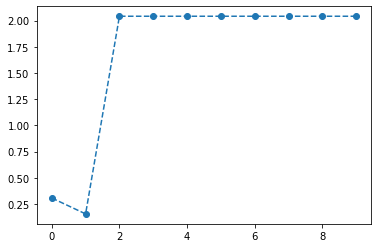

In [14]:
plt.plot(losses, '--o')